In [25]:
import numpy as np
from numpy import linalg as LA

from scipy import arange, conj, prod
import scipy.sparse.linalg as ssl

import matplotlib.pyplot as plt

import qutip as qt
from qutip import Qobj, tensor


from statistics import mean
import importlib

import pickle

import os

import scipy as sp


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def Binomial_code (mu,K,N,n_truncate):
    """
    Creates a N-fold rotational symmetric code out of a primitive state.
    Based on the paper arXiv:1901.08071v3


    Parameters
    ----------
    mu: int
        used to choose either zero-logical or one-logical state.
    K: int
        Truncation of the Binomial code, choose between 1-7
    N: int
        N-fold rotational symmetry choose between 2-5
    n_truncate:int
        Fock space cutoff


    :return:
    qutip ket-state
        Normalized N-fold rotational symmetric Binomial state.

    """
    out_p=0
    out_m=0
    for i in range(K+1):

        out_p += np.sqrt( sp.special.binom(K, i) )   *qt.fock(n_truncate, i*N)
        out_m += np.sqrt(sp.special.binom(K, i)) * (-1) **i * qt.fock(n_truncate, i * N)


    return ((out_p + (-1)**mu * out_m)*np.sqrt(2**(-K))).unit()

def grid( Delta, n_max, n_truncate):
    """
    hbar=1
    Creates a grid coherent state by squeezing and then displacing the vacuum
    Parameters PHYSICAL REVIEW A 97, 022341 (2018) eq:1
    the width of the Gaussian envelope can be chosen to be the same, so we choose k=delta
    Parameters
    ----------
    Delta: float
        Squeezing noise. between 0.25 and 0.5
    mu: int
        used to choose either zero-logical or one-logical GKPS state.
    n_max: int
        Determines the maximum number of peaks to be considered.
        The number of peaks is given by :math:`2 n_{max} + 1` Timo says 15. Maybe 20 to be safe?

    n_truncate: int
        Fock space cut-off.

    :return:
        qutip ket-state
        Normalized GKP state.

    """


    psi0 = qt.fock(n_truncate,0)
    squeezing= qt.squeeze(n_truncate, -np.log(Delta))

    out = 0
    for n in range(-n_max, n_max):
        out += (np.exp((- np.pi) * Delta ** 2 * (n) ** 2)* qt.displace(n_truncate,np.sqrt(np.pi) * (n))* squeezing) * psi0

    return out.unit()


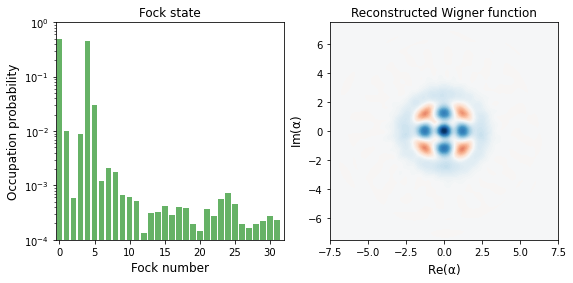

In [3]:
# load array of qutip density operators
import os
from matplotlib import pyplot as plt
import numpy as np
import qutip as qt


#here = os.path.dirname(os.path.abspath(__file__))
here=os.getcwd()
rho_fock2_reconstructed = qt.Qobj(np.load(os.path.join(here, "data", "rho_reconstructed_fock2.npy"), allow_pickle=True))
rho_binomial_reconstructed = qt.Qobj(np.load(os.path.join(here, "data", "rho_reconstructed_binomial.npy"), allow_pickle=True))

# plot wigner function

def plot_reconstruction(rho):
    fig, ax = qt.plot_wigner_fock_distribution(rho, figsize=(9, 4))
    ax[0].set_title("Fock state")
    ax[1].set_title("Reconstructed Wigner function")
    ax[0].set_yscale("log")
    ax[0].set_ylim([1e-4, 1])
    plt.show()


plot_reconstruction(rho_binomial_reconstructed)



In [62]:
rho_binomial_reconstructed

Quantum object: dims = [[32], [32]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[ 4.88454210e-01+0.00000000e+00j  2.55387684e-02+5.27295744e-03j
  -2.64050959e-03-1.01215948e-02j ...  1.40107025e-03-3.57153630e-03j
  -1.90536257e-04+5.81916200e-03j  3.16483833e-03-9.01816029e-04j]
 [ 2.55387684e-02-5.27295744e-03j  1.00573019e-02+0.00000000e+00j
  -1.67672381e-04+1.23812658e-03j ... -2.56950077e-04+4.76906261e-04j
  -7.72562676e-04-1.14627437e-04j  1.12931348e-03+3.80437450e-05j]
 [-2.64050959e-03+1.01215948e-02j -1.67672381e-04-1.23812658e-03j
   5.76963976e-04+0.00000000e+00j ...  1.98305292e-04+1.25785066e-04j
  -2.06776449e-04+1.27835956e-04j  2.76873999e-05-1.22498135e-04j]
 ...
 [ 1.40107025e-03+3.57153630e-03j -2.56950077e-04-4.76906261e-04j
   1.98305292e-04-1.25785066e-04j ...  2.26166475e-04+0.00000000e+00j
  -1.33436654e-05+1.16253915e-04j  2.13789319e-05-1.34061055e-05j]
 [-1.90536257e-04-5.81916200e-03j -7.72562676e-04+1.14627437e-04j
  -2.06776449e-04-1.278

In [64]:
qt.fidelity(grid_dm, rho_binomial_reconstructed)

0.9391065073548036

In [20]:
def beam_splitter(theta: float, phi: float, n_truncate: int)->qt.Qobj:
    """Generates the beam splitter operator.

    Args:
        theta (float): _description_
        phi (float): _description_
        n_truncate (int): Fock space truncation.

    Returns:
        bs_hamiltonian (qt.Qobj): The beam splitter operator.
    """
    a1 = qt.destroy(n_truncate)
    a2 = qt.destroy(n_truncate)
    bs_hamiltonian = (theta * (np.exp(1j*phi)*tensor(a1,a2.dag())-np.exp(-1j*phi)*tensor(a1.dag(),a2))).expm()
    return bs_hamiltonian



In [21]:
bs_h = beam_splitter(theta=np.pi/4, phi=0, n_truncate=32)

In [39]:
def beam_qp(bs_h: qt.Qobj, in1: qt.Qobj, in2: qt.Qobj, in1_prob: float, 
            in2_prob: float, target_dm: qt.Qobj, n_truncate: int, m1_ket: qt.Qobj, m1_value: float):
    """Runs a beamsplitter circuit

    Args:
        bs_h (qt.Qobj): the operater of a beamsplitter
        in1 (qt.Qobj): the state that is feeded into the beamsplitter in the first row
        in2 (qt.Qobj): the state that is feeded into the beamsplitter in the second row
        in1_prob (float): the probability of the state in1 in the previous round
        in2_prob (float): the probability of the state in2 in the previous round
        target_dm (qt.Qobj): the density matrix of the target state.
        n_truncate (int): Fock space truncation.
        m1_ket (qt.Qobj): eigenvector of the measurement1
        m1_value (float): eigenvalue of the measurement1

    Returns:
        res (dict): The dictionary of results.
    """
    mode12 = tensor(in1,in2)
    
    out_12 = bs_h * mode12*bs_h.dag()


    M1 = m1_ket*m1_ket.dag()
    M12 = tensor(M1, qt.qeye(n_truncate))# go outside

    out12_m = M12*out_12*M12.dag()
    out2_dm = out12_m.ptrace(1)
    

    # from Nielsen and Chuang 2.103
    # qutip: ptrace(0):means we will trace (1) and keep everything in 0
    out2_dm = out2_dm.unit()
    out2_fid = qt.fidelity(target_dm, out2_dm)

    tailnorm  =  ssl.norm(out2_dm.data[n_truncate-10:n_truncate-1,:])
    if tailnorm >= 0.01:
        print('warning: tailnorm = ',tailnorm)

    out2_prob_v = (M12.dag()*M12*out_12).tr()
    #nielson 2.141
    out2_prob = in1_prob*in2_prob*out2_prob_v*2

    #since there is a symmetry between this 
    res = {'m1_ket':m1_ket,'m1_value':m1_value,'out2_dm': out2_dm,'out2_prob': out2_prob,'out2_fid':out2_fid}
    return res

In [52]:
add = "data/iter2/"
K = 3
N = 2
n_truncate =32
Bino = Binomial_code(mu=0, K=K, N=N, n_truncate=n_truncate).unit()
Bino=Bino*Bino.dag()

qp_bound = 50
Q = qt.position(n_truncate)
MeasQ = Q.eigenstates()
eigv_Q = MeasQ[0]
eigvec_Q = MeasQ[1]

P = qt.momentum(n_truncate)
MeasP = P.eigenstates()
eigv_P = MeasP[0]
eigvec_P = MeasP[1]

delta_g = 0.4
grid_state = grid(delta_g,20,n_truncate)
grid_dm = grid_state * grid_state.dag()

fid_list = []
prob_1ist = []
out_list = []
whole_list = []

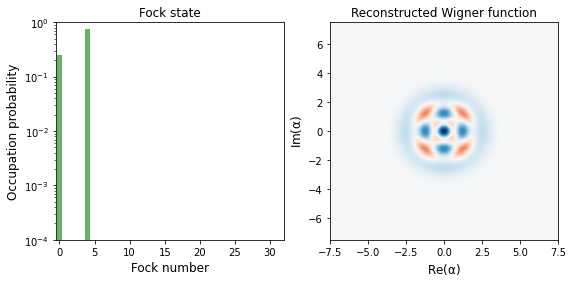

In [66]:
plot_reconstruction(Bino)

In [53]:
delta_g = 0.4
grid_state = grid(delta_g,20,n_truncate)
grid_dm = grid_state * grid_state.dag()


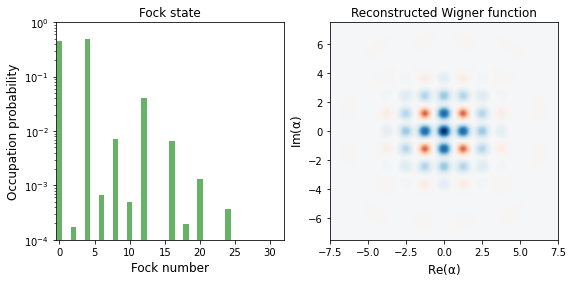

In [54]:
rho=grid_dm
title='test'
qp_bound=5
add=''
plot_reconstruction(rho)

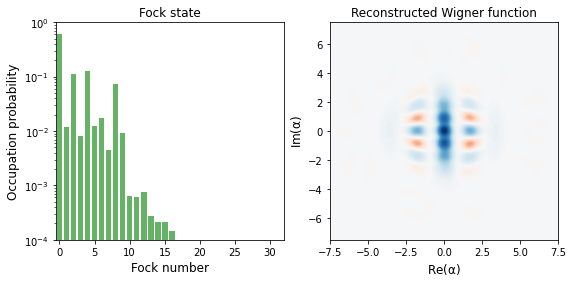

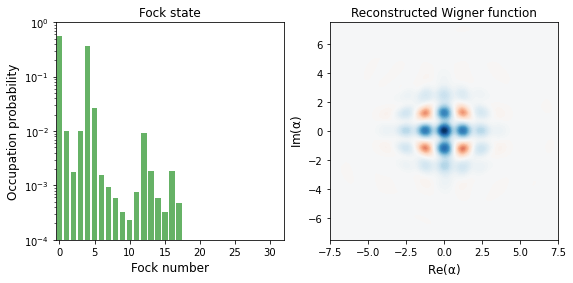

fid= 0.953679077140226
prob= (0.028214055745060404+1.2716781419668843e-14j)


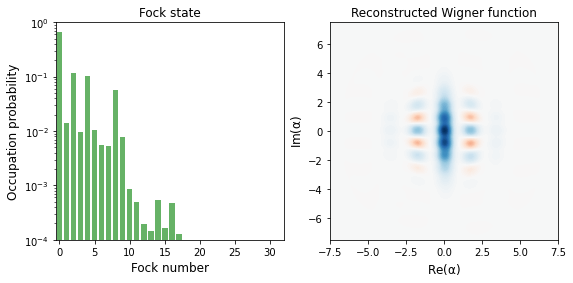

fid= 0.7593374930775197
prob= (0.00031083407879002936+3.3435325981627394e-15j)


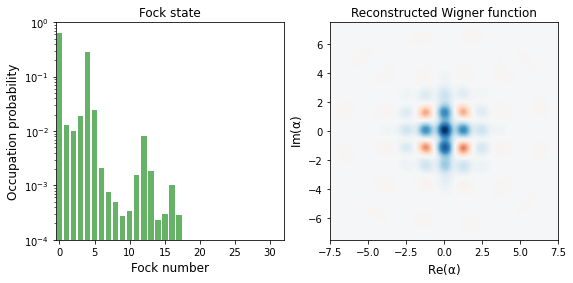

fid= 0.931194429410296
prob= (2.2377587871459883e-08+5.873911067604774e-20j)


In [60]:
mq_ll=[]
mq_vec_ll=eigvec_Q[int(n_truncate/2)]
in1_ket=rho_binomial_reconstructed
in2_ket=rho_binomial_reconstructed
in1_prob=1
in2_prob=1



cir1=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_1=cir1
out_dm1=out_1['out2_dm']
plot_reconstruction(out_dm1)


mq_vec_ll=eigvec_P[int(n_truncate/2)]
in1_ket=out_dm1
in2_ket=out_dm1
in1_prob=out_1['out2_prob']
in2_prob=out_1['out2_prob']


cir2=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_2=cir2
out_dm2=out_2['out2_dm']
plot_reconstruction(out_dm2)
print('fid=',out_2['out2_fid'])
print('prob=',out_2['out2_prob'])

mq_vec_ll=eigvec_Q[int(n_truncate/2)]
in1_ket=out_dm2
in2_ket=out_dm2
in1_prob=out_2['out2_prob']
in2_prob=out_2['out2_prob']


cir3=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_3=cir3
out_dm3=out_3['out2_dm']
plot_reconstruction(out_dm3)

print('fid=',out_3['out2_fid'])
print('prob=',out_3['out2_prob'])

mq_vec_ll=eigvec_P[int(n_truncate/2)]
in1_ket=out_dm3
in2_ket=out_dm3
in1_prob=out_3['out2_prob']
in2_prob=out_3['out2_prob']


cir4=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_4=cir4
out_dm4=out_4['out2_dm']
plot_reconstruction(out_dm4)

print('fid=',out_4['out2_fid'])
print('prob=',out_4['out2_prob'])

In [61]:
print('fid=',cir1['out2_fid'])
print('prob=',cir1['out2_prob'])

fid= 0.7654914598315026
prob= (0.3364671777376999+3.0661419658334385e-14j)


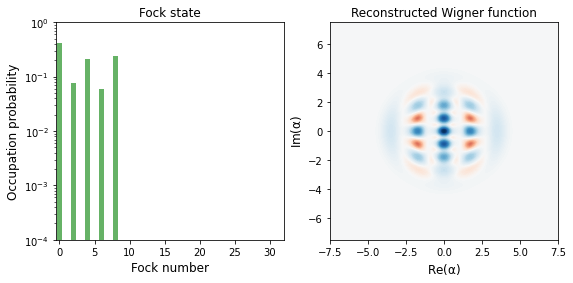

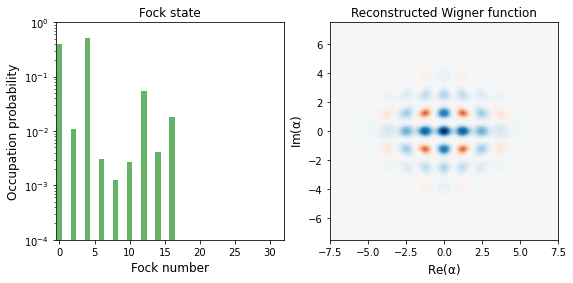

fid= 0.98290183993593
prob= 0.019498854059810163


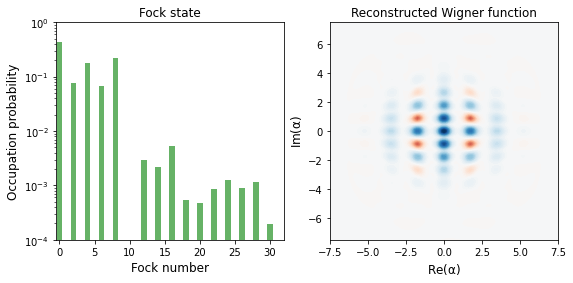

fid= 0.7076861907395658
prob= 0.00010199900592563276


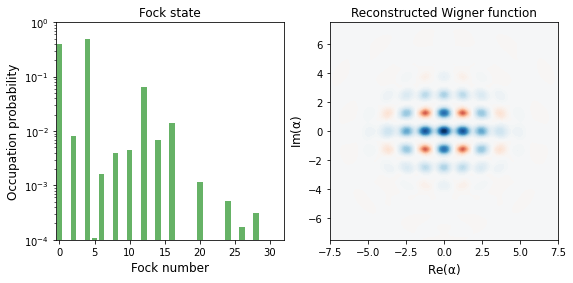

fid= 0.9839838639264525
prob= (2.965239627546046e-09-2.3046467565926023e-20j)


In [59]:
mq_ll=[]
mq_vec_ll=eigvec_Q[int(n_truncate/2)]
in1_ket=Bino
in2_ket=Bino
in1_prob=1
in2_prob=1


cir1=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_1=cir1
out_dm1=out_1['out2_dm']
plot_reconstruction(out_dm1)


mq_vec_ll=eigvec_P[int(n_truncate/2)]
in1_ket=out_dm1
in2_ket=out_dm1
in1_prob=out_1['out2_prob']
in2_prob=out_1['out2_prob']


cir2=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_2=cir2
out_dm2=out_2['out2_dm']
plot_reconstruction(out_dm2)
print('fid=',out_2['out2_fid'])
print('prob=',out_2['out2_prob'])

mq_vec_ll=eigvec_Q[int(n_truncate/2)]
in1_ket=out_dm2
in2_ket=out_dm2
in1_prob=out_2['out2_prob']
in2_prob=out_2['out2_prob']


cir3=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_3=cir3
out_dm3=out_3['out2_dm']
plot_reconstruction(out_dm3)

print('fid=',out_3['out2_fid'])
print('prob=',out_3['out2_prob'])

mq_vec_ll=eigvec_P[int(n_truncate/2)]
in1_ket=out_dm3
in2_ket=out_dm3
in1_prob=out_3['out2_prob']
in2_prob=out_3['out2_prob']


cir4=beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,grid_dm,n_truncate,m1_ket=mq_vec_ll,m1_value=0)
out_4=cir4
out_dm4=out_4['out2_dm']
plot_reconstruction(out_dm4)

print('fid=',out_4['out2_fid'])
print('prob=',out_4['out2_prob'])

In [65]:
qt.fidelity(grid_dm, Bino)

0.9411910125758436